<a href="https://colab.research.google.com/github/MichalMichniak/pytorch_projects/blob/main/irys_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import torch
print(torch.__version__)
import torch.nn as nn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

1.13.1+cpu


## Data manipulation

In [47]:
irys_data = load_iris()
data = irys_data.data
target = irys_data.target
ft_labels = irys_data.feature_names
print("target data type:",target.dtype)

target data type: int32


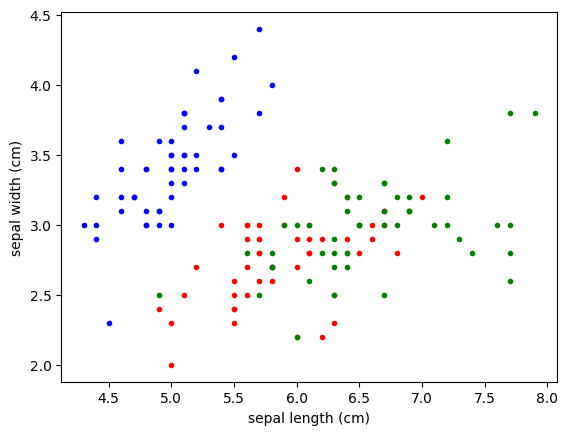

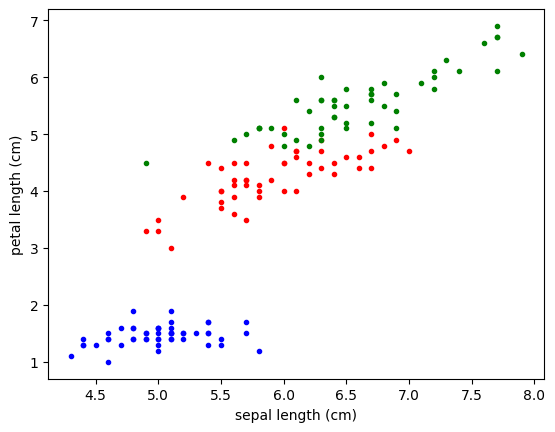

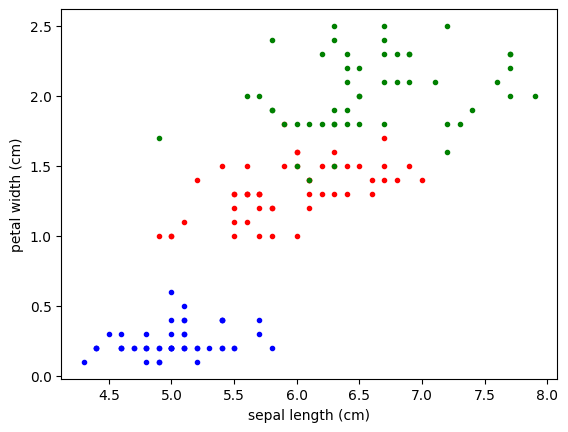

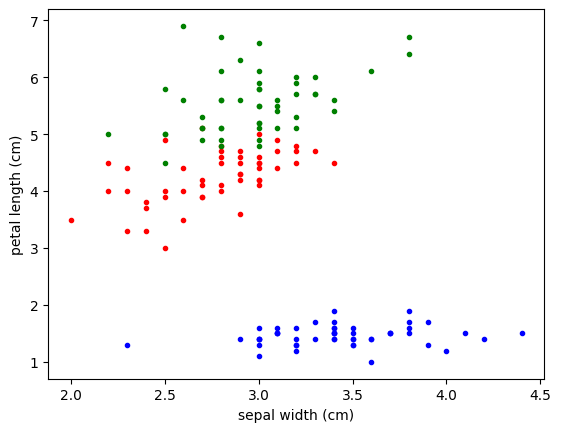

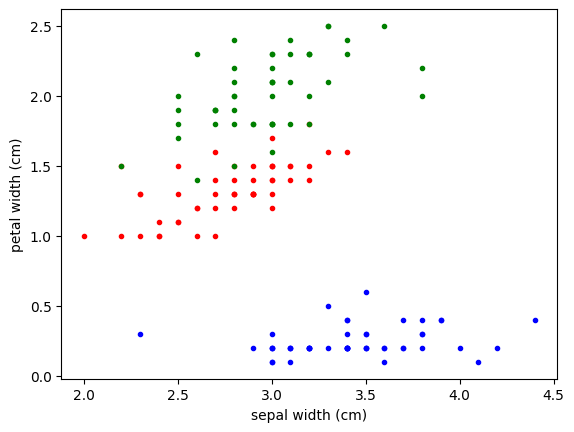

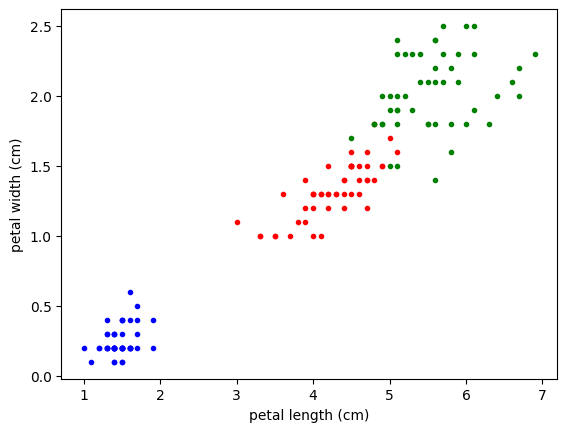

In [48]:
### visualisation of data
for i in range(len(ft_labels)):
    for j in range(i+1,len(ft_labels)):
        for k in range(len(data[:,i])):
            if target[k] == 0:
                plt.plot(data[k,i],data[k,j], 'b.')
            elif target[k] == 1:
                plt.plot(data[k,i],data[k,j], 'r.')
            else:
                plt.plot(data[k,i],data[k,j], 'g.')
        plt.xlabel(ft_labels[i])
        plt.ylabel(ft_labels[j])
        plt.show()

In [49]:
#data standarization
scaler = StandardScaler()
standarizated_data = scaler.fit_transform(data)

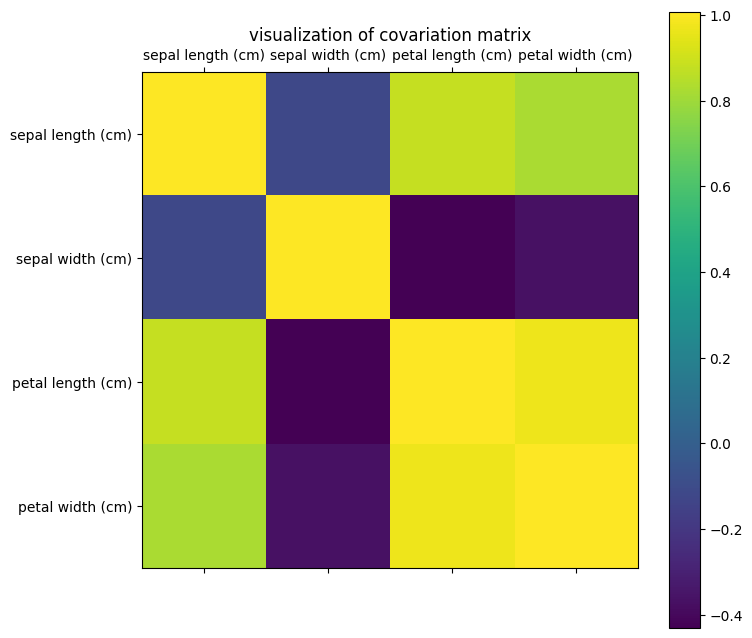

In [50]:

covariation_matrix = np.cov(standarizated_data.T)
fig = plt.figure()
axes = fig.add_subplot(111)
fig.set_size_inches([8,8])
mtsh = axes.matshow(covariation_matrix)
fig.colorbar(mtsh)
axes.set_xticks([i for i in range(len(ft_labels))], ft_labels)
axes.set_yticks([i for i in range(len(ft_labels))], ft_labels)
axes.set_title("visualization of covariation matrix")
plt.show()

from standarized covariance matrix we see that petal width and petal length are highly correlated and both of them are slightly correlated with sepal length. So those features have a lot of the mutual inforamtion. So different highly correlated features may highly influence model with same information 

In [51]:
# reduction of dimentionality
data_tensor = torch.tensor(standarizated_data)
U,S,V = torch.pca_lowrank(data_tensor)
print("singular values:",S)
print("feature vectors:",V[:,:3])
V = V[:,:3]
new_dataset = torch.matmul(data_tensor,V)

singular values: tensor([20.9231, 11.7092,  4.6919,  1.7627], dtype=torch.float64)
feature vectors: tensor([[-0.5211, -0.3774, -0.7196],
        [ 0.2693, -0.9233,  0.2444],
        [-0.5804, -0.0245,  0.1421],
        [-0.5649, -0.0669,  0.6343]], dtype=torch.float64)


## Model creation

In [52]:
class NeuralNetwork(nn.Module):
    def __init__(self,input_dim) -> None:
        super().__init__()
        self.firstFC = nn.Linear(input_dim,10)
        self.secondFC = nn.Linear(10,10)
        self.thirdFC = nn.Linear(10,7)
        self.lastFC = nn.Linear(7,3)
    
    def forward(self,x):
        x = self.firstFC(x)
        x = torch.sigmoid(x)
        x = self.secondFC(x)
        x = torch.sigmoid(x)
        x = self.thirdFC(x)
        x = torch.sigmoid(x)
        x = self.lastFC(x)
        return nn.functional.softmax(x)



In [53]:
## split train data and test data and encode results
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
target = pd.DataFrame(target,columns=["species"])
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(target)
print(f"encoded values: {encoder.categories_}")
target_numpy_array = target.copy()
target = encoder.transform(target).toarray()
target = torch.tensor(target)
xtrain, xtest, ytrain, ytest = train_test_split(new_dataset, target, test_size=0.2, random_state=2)

encoded values: [array([0, 1, 2])]


In [54]:
model_0 = NeuralNetwork(3)
print(model_0)

NeuralNetwork(
  (firstFC): Linear(in_features=3, out_features=10, bias=True)
  (secondFC): Linear(in_features=10, out_features=10, bias=True)
  (thirdFC): Linear(in_features=10, out_features=7, bias=True)
  (lastFC): Linear(in_features=7, out_features=3, bias=True)
)


In [55]:
def train(model : NeuralNetwork, x, y, xtest, ytest, nr_epoch, learning_rate = 1e-5):
    test_history = []
    test_loss = []
    train_history = []
    loss_func = nn.CrossEntropyLoss()
    model.float()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    for epoch in range(nr_epoch):
        running_loss = 0.0
        for i in range(len(x)):
            y_pred = model.forward(x[i].float())
            error = loss_func(y_pred, y[i])
            model.zero_grad()
            error.backward()
            optimizer.step()
            running_loss += error.item()
        

        # evaluate model at end of epoch
        acc = 0.0
        avg_loss = 0.0
        for i in range(len(xtest)):
            y_pred = model(xtest[i].float())
            acc += (y_pred.round() == ytest[i]).all().float()
            err = loss_func(y_pred, ytest[i])
            avg_loss += err.item()
            #print(acc)
        acc = float(acc)/len(xtest)
        print(f'[{epoch + 1}] loss: {running_loss/len(x):.3f}', f"accuracy: {acc}")
        test_history.append(acc)
        test_loss.append(avg_loss/len(xtest))
        train_history.append(running_loss/len(x))

    return train_history, test_history, test_loss


In [56]:
model_0.eval()
train_history, test_history, test_loss = train(model_0,xtrain,ytrain,xtest,ytest,34,0.03)

[1] loss: 1.125 accuracy: 0.0


C:\Users\nikos\AppData\Local\Temp\ipykernel_1108\1429860916.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.softmax(x)


[2] loss: 1.122 accuracy: 0.0
[3] loss: 1.119 accuracy: 0.0
[4] loss: 1.117 accuracy: 0.0
[5] loss: 1.115 accuracy: 0.0
[6] loss: 1.114 accuracy: 0.0
[7] loss: 1.112 accuracy: 0.0
[8] loss: 1.110 accuracy: 0.0
[9] loss: 1.108 accuracy: 0.0
[10] loss: 1.106 accuracy: 0.0
[11] loss: 1.100 accuracy: 0.0
[12] loss: 1.086 accuracy: 0.0
[13] loss: 1.031 accuracy: 0.7333333333333333
[14] loss: 0.917 accuracy: 0.7333333333333333
[15] loss: 0.861 accuracy: 0.7333333333333333
[16] loss: 0.825 accuracy: 0.9
[17] loss: 0.789 accuracy: 0.9
[18] loss: 0.756 accuracy: 0.8666666666666667
[19] loss: 0.728 accuracy: 0.8666666666666667
[20] loss: 0.703 accuracy: 0.9
[21] loss: 0.679 accuracy: 0.9
[22] loss: 0.657 accuracy: 0.9
[23] loss: 0.637 accuracy: 0.9333333333333333
[24] loss: 0.623 accuracy: 0.9666666666666667
[25] loss: 0.613 accuracy: 0.9666666666666667
[26] loss: 0.606 accuracy: 0.9666666666666667
[27] loss: 0.602 accuracy: 1.0
[28] loss: 0.601 accuracy: 1.0
[29] loss: 0.599 accuracy: 1.0
[30] 

## Model Validation

accuracy on whole dataset: 0.9733333333333334


C:\Users\nikos\AppData\Local\Temp\ipykernel_1108\1429860916.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.softmax(x)


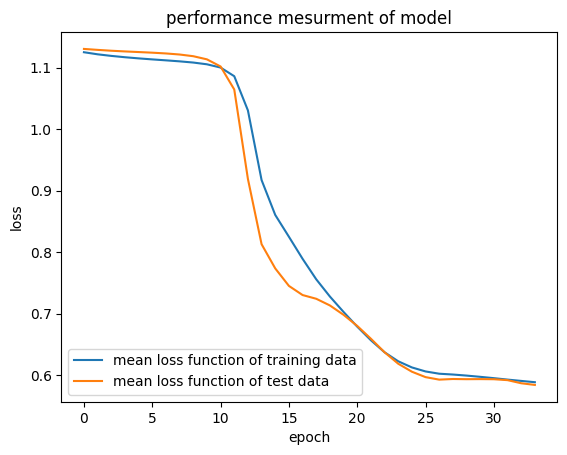

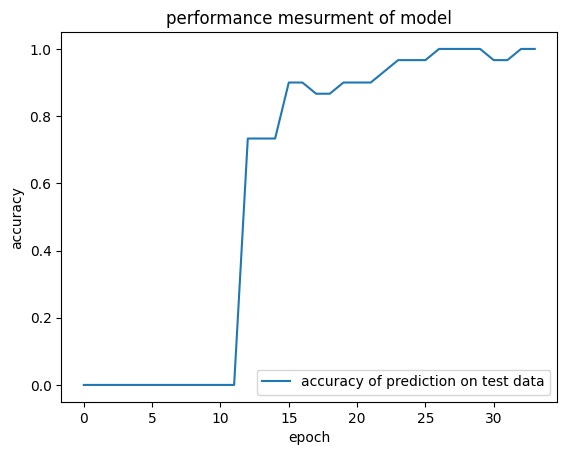

In [57]:
acc = 0.0
for i in range(len(new_dataset)):
    y_pred = model_0(new_dataset[i].float())
    acc += (y_pred.round() == target[i]).all().float()
    #print(acc)
acc = float(acc)/len(new_dataset)
print(f"accuracy on whole dataset: {acc}")

plt.plot(train_history,label="mean loss function of training data")
plt.plot(test_loss, label="mean loss function of test data")
plt.legend(loc='lower left')
plt.title("performance mesurment of model")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.plot(test_history, label="accuracy of prediction on test data")
plt.legend(loc='lower right')
plt.title("performance mesurment of model")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

C:\Users\nikos\AppData\Local\Temp\ipykernel_1108\1429860916.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.softmax(x)


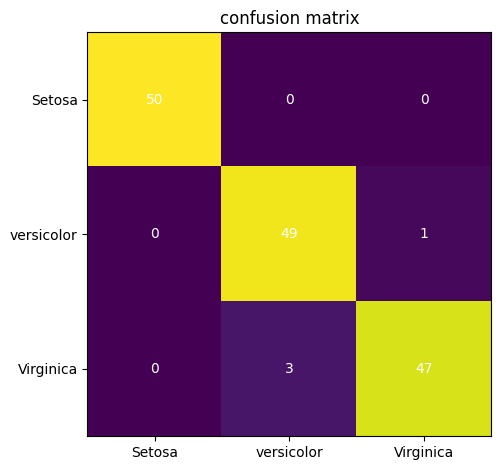

In [58]:
## confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = []
for i in range(len(new_dataset)):
    y = (model_0(new_dataset[i].float()).round()).detach().numpy()
    if np.sum(y) != 1:
        continue
    y_pred.append(np.sum(y*np.array([0,1,2])))
cf_mat = confusion_matrix(target_numpy_array, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cf_mat)
ax.set_title("confusion matrix")
ax.set_xticks([0,1,2],["Setosa", "versicolor", "Virginica"])
ax.set_yticks([0,1,2],["Setosa", "versicolor", "Virginica"])
for i in range(len(cf_mat)):
    for j in range(len(cf_mat[0])):
        ax.text(j, i, cf_mat[i, j], ha="center", va="center", color="w")
fig.tight_layout()
plt.show()


In [59]:
path = "./irys_model.pth"
torch.save(model_0.state_dict(), path) 